In [30]:

import os
import fnmatch
import numpy as np
import torch
from tqdm import tqdm
import random
import json
from torch.utils.data import DataLoader

from dual_network import Dual3DCNN6 as Dual
# from Dataset_json import PXAI_Dataset
from decayLR import DecayLR
import torch
from torch.utils.data import Dataset
import SimpleITK as sitk
import numpy as np
import glob
from utilities import create_list_from_master_json, read_json_file, split_data
import os
import glob
import random
from torch.utils.data import Dataset, DataLoader


In [31]:
def list_patient_folders(data_path):
    """
    List all directories in the base_directory.
    Each directory represents a patient.
    """
    try:
        patient_folders = [name for name in os.listdir(data_path)
                           if os.path.isdir(os.path.join(data_path, name))]
        return patient_folders
    except FileNotFoundError:
        print(f"Directory {data_path} was not found.")
        return []

# Specify the directory where the patient folders are located
data_path = '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton'

# Get the list of patient folders
patient_list = list_patient_folders(data_path)
print(len(patient_list))
print(patient_list)

26
['DBP_OP013', 'DBP_OP008', 'DBP_OP017', 'DBP_OP024', 'DBP_OP004', 'DBP_OP010', 'DBP_OP020', 'DBP_OP009', 'DBP_OP027', 'DBP_OP025', 'DBP_OP014', 'DBP_OP012', 'DBP_OP001', 'DBP_OP018', 'DBP_OP026', 'DBP_OP007', 'DBP_OP006', 'DBP_OP029', 'DBP_OP011', 'DBP_OP015', 'DBP_OP022', 'DBP_OP021', 'DBP_OP023', 'DBP_OP032', 'DBP_OP028', 'DBP_OP002']


In [33]:
# Set parameters
starting_epoch = 0
decay_epoch = 20
final_epoch = 30
learning_rate = 0.0001
batchsize = 5
device_num = 1
lambda_reg = 0.000001

# Condition for saving list
save_list = False


exception_list = ['']


In [34]:
import glob
import os
import json

import glob
import os
import json

def prepare_data(data_dir, patient_ids):
    """
    Scan through the patient folders to find pCT and rCT files and match rCT files with entries in nrrd_file_info.json.
    """
    pct_paths = []
    rct_paths = []
    reg_pos = []  
    idxs = ["P1", "P2", "P3"]
    # Load the JSON data
    with open(os.path.join(data_dir, 'nrrd_file_info.json'), 'r') as json_file:
        nrrd_info = json.load(json_file)
    
    for patient_id in patient_ids:
        patient_folder = os.path.join(data_dir, patient_id)
        file = glob.glob(os.path.join(patient_folder))
        for idx in idxs:
            if os.path.basename(file).split('_')[2] == idx:
                        
                # Find planning CT (pCT) and repeated CTs (rCT)
                planning_ct = glob.glob(os.path.join(patient_folder, '*repeatedCT*'))
                repeated_cts = glob.glob(os.path.join(patient_folder, '*planningCT*'))
                
                if planning_ct:
                    # pct_paths.extend(planning_ct)
                    for rct_path in repeated_cts:
                        rct_filename = os.path.basename(rct_path)
                        # Nested loop to match the rct_filename with repeatedCT_filename in the JSON
                        for patient in nrrd_info:
                            for plan_detail in patient['plan_details']:
                                for eval_exam in plan_detail['evaluation_examinations']:
                                    if eval_exam['repeatedCT_filename'] == rct_filename:
                                        reg_pos.append([eval_exam['final_translation_coordinate']['x'],
                                                        eval_exam['final_translation_coordinate']['y'],
                                                        eval_exam['final_translation_coordinate']['z']])
                                        rct_paths.append(rct_path)
                                        pct_paths.append(planning_ct)
                                        break  # Assuming unique filenames, stop searching once a match is found
                
            else: 
                pass
    return pct_paths, rct_paths, reg_pos





In [41]:
import re

def prepare_data(data_dir, patient_ids):
    pct_paths = []
    rct_paths = []
    reg_pos = []  
    plan_ids = ["P1", "P2"]

    # Load the JSON data
    with open(os.path.join(data_dir, 'nrrd_file_info.json'), 'r') as json_file:
        nrrd_info = json.load(json_file)
    
    for patient_id in patient_ids:
        patient_folder = os.path.join(data_dir, patient_id)
        all_files = glob.glob(os.path.join(patient_folder, '*.nrrd'))
        
        for plan_id in plan_ids:
            planning_ct = [f for f in all_files if f.endswith(f"{plan_id}_planningCT.nrrd")]
            
            # Use regex to find repeated CT files that match the plan_id pattern
            pattern = re.compile(f".*{plan_id}_repeatedCT\d*\.nrrd")
            repeated_ct_files = [f for f in all_files if pattern.match(f)]
            print(f"Repeated CT files for {plan_id}: {repeated_ct_files}")

            # Process each planning CT file
            if planning_ct and repeated_ct_files:
                # print(f"Planning CT files for {plan_id}: {planning_ct}")

                # Associate each planning CT with its corresponding repeated CTs
                for rct_path in repeated_ct_files:
                    rct_filename = os.path.basename(rct_path)
                    
                    # Look for the corresponding registration information in the JSON data
                    for patient in nrrd_info:
                        if patient['id'] == patient_id:
                            for plan_detail in patient['plan_details']:


                                for eval_exam in plan_detail['evaluation_examinations']:
                                    # print(f"Comparing {rct_filename} with {eval_exam['repeatedCT_filename']}")
                                    if rct_filename == eval_exam['repeatedCT_filename']:
                                        # print("Match found")
                                        reg_pos.append([eval_exam['final_translation_coordinate']['x'],
                                                        eval_exam['final_translation_coordinate']['y'],
                                                        eval_exam['final_translation_coordinate']['z']])
                                        rct_paths.append(rct_path)
                                        pct_paths.append(planning_ct)

                                        # Assuming unique filenames, stop searching once a match is found
                                        break
                                reg_pos_array = np.array(reg_pos, dtype=np.float32)

    return pct_paths, rct_paths, reg_pos_array






# Prepare training, validation, and testing datasets
pct_train, rct_train, pos_train = prepare_data(data_path, patient_list)
pct_val, rct_val, pos_val = prepare_data(data_path, patient_list)
pct_test, rct_test, pos_test = prepare_data(data_path, patient_list)


Repeated CT files for P1: ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT17.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT30.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT9.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT14.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT28.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT27.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT18.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT5.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT40.nrrd', '/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_repeatedCT32.nrrd', '/home/shahpouriz/Data/DBP_newDATA/

In [42]:
print(len(pct_train))
print(len(rct_train))
print(len(pos_train))

print(pct_train[:10])
print(rct_train[:10])
print(pos_train[:2])

1225
1225
1225
[['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd'], ['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd/proton/DBP_OP013/DBP_OP013_P1_planningCT.nrrd']]
['/home/shahpouriz/Data/DBP_newDATA/DBP/nrrd

In [54]:
import numpy as np
import SimpleITK as sitk
import torch
from torch.utils.data import Dataset, DataLoader

class PatientDataset(Dataset):
    def __init__(self, pct_paths, rct_paths, pos, transform=None):
        """
        Initializes the dataset with paths to pCT and rCT images.
        """
        self.pct_paths = pct_paths
        self.rct_paths = rct_paths
        self.pos = pos
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.pct_paths)

    def __getitem__(self, idx):
        try:
            pct_path = self.pct_paths[idx]
            rct_path = self.rct_paths[idx]
            pos = self.pos[idx]

            # Read and normalize the images
            pct_img = self.read_nrrd_file(pct_path)
            if pct_img is None:
                raise ValueError(f"Failed to read pCT image: {pct_path}")


            rct_img = self.read_nrrd_file(rct_path)
            if pct_img is None:
                raise ValueError(f"Failed to read pCT image: {pct_path}")
            
            pct_img = self.normalize(pct_img)
            rct_img = self.normalize(rct_img)

            # Resize and adjust spacing
            pct_img_resized = self.resize_and_adjust_spacing(pct_img)
            rct_img_resized = self.resize_and_adjust_spacing(rct_img)



            # Convert images to PyTorch tensors and add a channel dimension
            # pct_tensor = torch.from_numpy(np.expand_dims(pct_img_resized, axis=0))
            # rct_tensor = torch.from_numpy(np.expand_dims(rct_img_resized, axis=0))

            pct_tensor = pct_img_resized
            rct_tensor = rct_img_resized

            return pct_tensor, rct_tensor, pos
        except Exception as e:
            print(f"Error processing file at index {idx}: {e}")
            raise





    def read_nrrd_file(self, filepath):
        try:
            if isinstance(filepath[0], list):
                filepath = filepath[0]  # Assuming the first file is the desired one if a list is provided
            # print(f"Filepath is a list, expected a single path. {filepath}")
            # print(f"Filepath is a list, expected a single path. {filepath[0]}")
            sitk_img = sitk.ReadImage(filepath)
            img = sitk.GetArrayFromImage(sitk_img).astype(np.float32)
            if img.ndim > 3:
                img = np.squeeze(img)
            return img
        except Exception as e:
            print(f"Failed to read {filepath}: {e}")
            return None




    def normalize(self, volume, min=-1000, max=1000):
        """
        Normalizes a volume to the range [0, 1] based on specified min and max values.
        """
        volume[volume < min] = min
        volume[volume > max] = max
        volume = (volume - min) / (max - min)
        volume = volume.astype("float32")
        return volume
    
    def resize_and_adjust_spacing(self, volume, new_size=(256, 256, 256), new_spacing=(1, 1, 1)):
        """
        Resizes the volume to the specified size and adjusts the spacing.
        """
        sitk_img = sitk.GetImageFromArray(volume)

        # Resize the image
        sitk_resized_img = sitk.Resample(sitk_img, new_size, sitk.Transform(), sitk.sitkLinear, sitk_img.GetOrigin(),
                                        new_spacing, sitk_img.GetDirection(), 0, sitk_img.GetPixelID())
        
        # Get the resized volume as a numpy array
        resized_volume = sitk.GetArrayFromImage(sitk_resized_img).astype(np.float32)
        
        # # Print out the size of the resized volume
        # print("Resized volume size:", resized_volume.shape)
        
        # Check if the resized volume has the desired size
        if resized_volume.shape != new_size:
            # Handle the case where the size does not match (e.g., skip the image)
            raise RuntimeError(f"Resized volume size {resized_volume.shape} does not match the desired size {new_size}")

        return resized_volume





    

# Initialize datasets
train_dataset = PatientDataset(pct_train, rct_train, pos_train)
val_dataset = PatientDataset(pct_val, rct_val, pos_val)
test_dataset = PatientDataset(pct_test, rct_test, pos_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)






In [55]:
count = 0
for pct_tensor, rct_tensor, pos in train_dataset:
    print("pCT Tensor:", pct_tensor.shape)
    print("rCT Tensor:", rct_tensor.shape)
    print("Position:", pos)
    count += 1
    if count == 2:
        break



pCT Tensor: (256, 256, 256)
rCT Tensor: (256, 256, 256)
Position: [-0.17846 -0.16536 -0.71716]
pCT Tensor: (256, 256, 256)
rCT Tensor: (256, 256, 256)
Position: [ 1.28169 -1.37419 -0.46331]


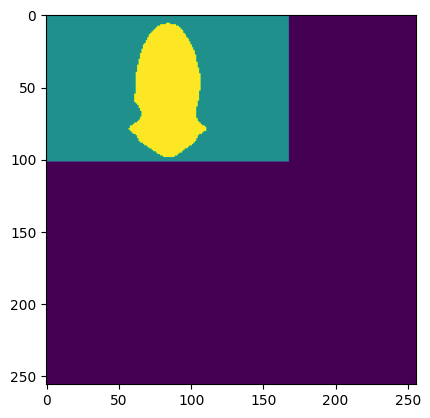

In [65]:
import matplotlib.pyplot as plt

plt.imshow(pct_tensor[50,:,:])


In [45]:

# Build model
print('Initializing model...')
model = Dual(width=512, height=512, depth=512)
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss
print('Defining loss...')
mae_loss = torch.nn.L1Loss()
mse_loss = torch.nn.MSELoss()

# Define optimizer
print('Defining optimizer...')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Define scheduler
print('Defining scheduler...')
lr_lambda = DecayLR(epochs=final_epoch, offset=0, decay_epochs=decay_epoch).step
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)


Initializing model...
Defining loss...
Defining optimizer...
Defining scheduler...


In [46]:
# Initialize model
model = Dual(width=512, height=512, depth=512)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss
mae_loss = torch.nn.L1Loss()
mse_loss = torch.nn.MSELoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))

# Define scheduler
lr_lambda = DecayLR(epochs=final_epoch, offset=0, decay_epochs=decay_epoch).step
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

# Training loop
for epoch in range(starting_epoch, final_epoch):
    mae_list = []
    model.train()  # Set model to training mode
    for i, (pCT, rCT, reg) in enumerate(train_loader):
        pCT = pCT.to(device)
        rCT = rCT.to(device)
        reg = reg.to(device)  # Access the element of the list and move it to the device



        # Forward pass
        output = model(pCT, rCT)
        output = output.to(torch.float32)
        reg = reg.to(torch.float32)
        # Calculate loss
        loss_output = mse_loss(output, reg)

            
        # L1 Regularization
        l1_reg = torch.tensor(0., requires_grad=True).to(device)
        for name, param in model.named_parameters():
            l1_reg = l1_reg + torch.norm(param, 1)
        loss_output += lambda_reg * l1_reg
        
        # Backpropagation
        optimizer.zero_grad()
        loss_output.backward()
        optimizer.step()
        
        # Logging
        mae_list.append(loss_output.item())
        mean_mae = np.mean(mae_list)
        print(f'Epoch: {epoch}/{final_epoch}, Batch: {i}/{len(train_loader)}, Loss_avg: {mean_mae}')
    
    # Validation loop
    model.eval()  # Set model to evaluation mode
    val_loss = []
    with torch.no_grad():
        for j, (pCT_val, rCT_val, reg_val) in enumerate(val_loader):
            pCT_val = pCT_val.to(device)
            rCT_val = rCT_val.to(device)
            reg_val = reg_val.to(device)
            
            output_val = model(pCT_val, rCT_val)
            loss_output_val = mae_loss(output_val, reg_val)
            
            val_loss.append(loss_output_val.item())
            mean_val_loss = np.mean(val_loss)
            print(f'Epoch: {epoch}/{final_epoch}, Batch: {j}/{len(val_loader)}, Loss_avg: {mean_val_loss}')
    
    # Adjust learning rate
    lr_scheduler.step(mean_val_loss)
    
    save_dir = '/home/shahpouriz/Data/DBP_Project/LOG'
    fname_comment = 'test'
    loss_file = fr'/home/shahpouriz/Data/DBP_Project/LOG/loss_dose_json_simpleModel_{fname_comment}.txt'

    # Save model
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    
    current_valid_mae = val_loss[-1]    
    if current_valid_mae <= best_mae and epoch > 0:
        best_mae = current_valid_mae
        torch.save(model.state_dict(),f'{save_dir}/model_weights_dose_{epoch+1}_{fname_comment}.pt')
    with open(loss_file, 'a') as f: #a-append
        f.write(f'Epoch: {epoch+1}/{final_epoch}, Loss: {mean_mae}, Val: {mean_val_loss}\n')


Epoch: 0/30, Batch: 0/1225, Loss_avg: 1.471001148223877


KeyboardInterrupt: 